![Lithology_Estimation.png](https://datasciencecc.s3.us-east-2.amazonaws.com/Lithology+_Estimation.png)


**Es importante resaltar que este laboratorio es con fines personales y academicos. Cualquier resultados que se tenga del estudio no tiene que reflejarse completamente a la realidad**


# <p style="background-color: rgb(73,68,33); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 1. Introdution:</p>


This notebook deals with the analysis of IP and MAG geophysical data, which were collected in the surface geophysical exploration campaign that was carried out. One of the main objectives of the study is to correlate the data so that it is possible to compare the behaviour of each variable with the others, taking into account the spatial position of each parameter.

the first step in approaching the study is to identify trends in the behaviour of the properties that were acquired in the field.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statistics as st
import statsmodels.graphics.gofplots as sm
import seaborn as sns
from IPython.display import set_matplotlib_formats
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap


from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel('Geophysics_surface.xlsx','Res')
df_mag = pd.read_excel('Geophysics_surface.xlsx','Mag')
df_drill = pd.read_excel('Geophysics_drill.xlsx','All_Data')
df_na = df.dropna()
df_mag_na = df_mag.dropna()
df_emp = df

# <p style="background-color: rgb(73,68,33); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 2. Field data processing:</p>


the following functions are written to work with any of the 3 properties that were acquired in the field taking into account their nomenclature and to which data frame the variable belongs.


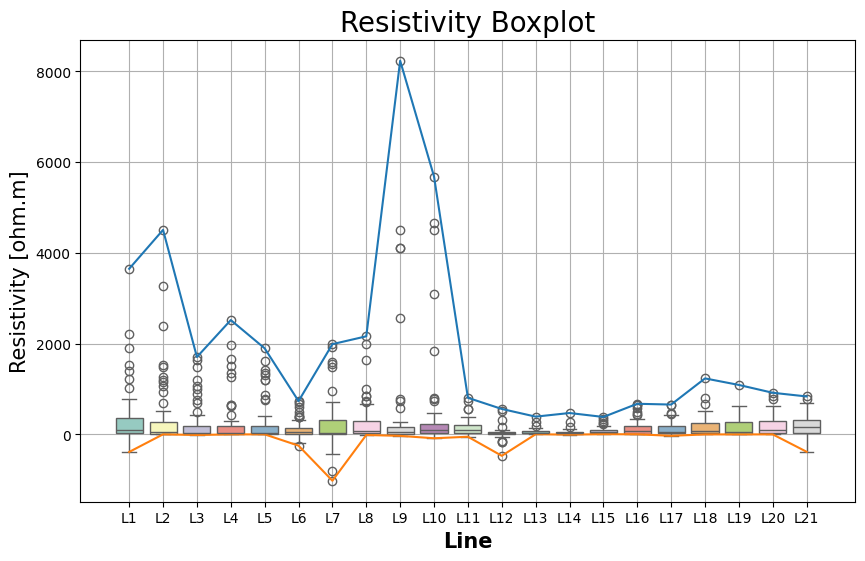

In [3]:
variables = {'Char': ('r-','Chargeability Boxplot','Chargeability [mV/V]','Chargeability'),
                'Res': ('b-','Resistivity Boxplot', 'Resistivity [ohm.m]','Resistivity'),
                'Mag': ('k-','Magnetometry Boxplot', 'Magnetometry [nT]', 'Magnetic susceptibility'),
             'Lithology':('k-','Lithology', 'Lithology', 'Lithology')
                  }
                          
def boxplot_lineas(df,Var):
    tips = sns.load_dataset("tips")
    fig,ax = plt.subplots(figsize=(10, 6))

    # Create a boxplot with different hues for different day of the week
    
    sns.boxplot(x="Linea", y=Var, data=df, hue='Linea', palette="Set3")

    top_values = pd.DataFrame(df.groupby("Linea")[Var].quantile(1))
    bot_values = pd.DataFrame(df.groupby("Linea")[Var].quantile(0))

    top_values = top_values.sort_values(by='Linea', key=lambda x: x.str[1:].astype(int))
    bot_values = bot_values.sort_values(by='Linea', key=lambda x: x.str[1:].astype(int))

    num_linea= list(range(21))

    ax.plot(num_linea,top_values)
    ax.plot(num_linea,bot_values)
    plt.grid()
    plt.ylabel(f"{variables[Var][2]}",fontsize=15)
    plt.xlabel('Line',fontsize=15,fontweight="bold")
    plt.title(f"{variables[Var][1]}",fontsize=20)
    
    # Show the plot
    #
    plt.show()
boxplot_lineas(df,'Res')

In [4]:
def quantiles(df,Var):
    Q3=np.quantile(df[Var],0.75)
    Q1=np.quantile(df[Var],0.25)
    IQR=Q3-Q1
    IQR=round(IQR, 2)
    Min_Whisker=Q1-(1.5*IQR)
    Min_Whisker=round(Min_Whisker, 2)
    Max_Whisker=Q3+(1.5*IQR)
    Max_Whisker=round(Max_Whisker, 2)
    return (IQR, Max_Whisker, Min_Whisker)
    
quantiles(df_na,'Char')

(np.float64(13.24), np.float64(43.3), np.float64(-9.65))

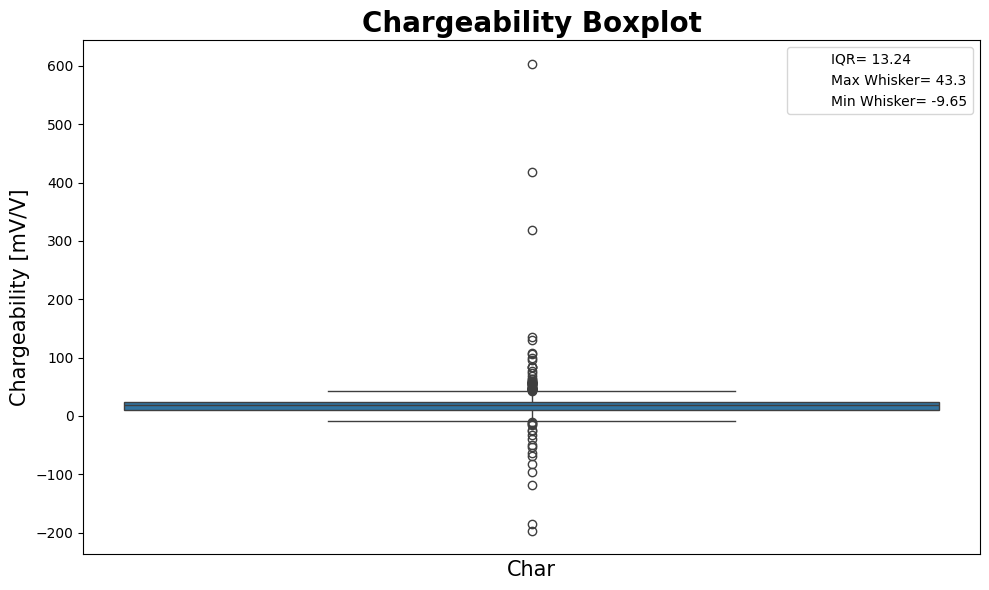

In [5]:
df_na = df.dropna()
df_mag_na = df_mag.dropna()

quan = {'Char': (df_na),
                'Res': (df_na),
                'Mag': (df_mag_na)
                  }

def boxplot_all(df,Var):

    fig,ax = plt.subplots(figsize=(10, 6))
    df_na = df.dropna()
    sns.boxplot(y=Var,data=df)

    (IQR, Max_Whisker, Min_Whisker) = quantiles(quan[Var],Var)
    
    plt.plot([], ' ', label='IQR= ' + str(IQR))
    plt.plot([], ' ', label='Max Whisker= ' + str(Max_Whisker))
    plt.plot([], ' ', label='Min Whisker= ' + str(Min_Whisker))

    plt.title(f"{variables[Var][1]}",fontsize=20,fontweight="bold")
    plt.ylabel(f"{variables[Var][2]}",fontsize=15)
    plt.xlabel(Var,fontsize=15)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xticks([])

    plt.tight_layout()
boxplot_all(df,'Char')

Assessing Chargeability from a unified dataset reveals a significant number of outliers. On this occasion we will observe the behaviour of these outliers across the acquisition lines to determine if any trends can be identified.


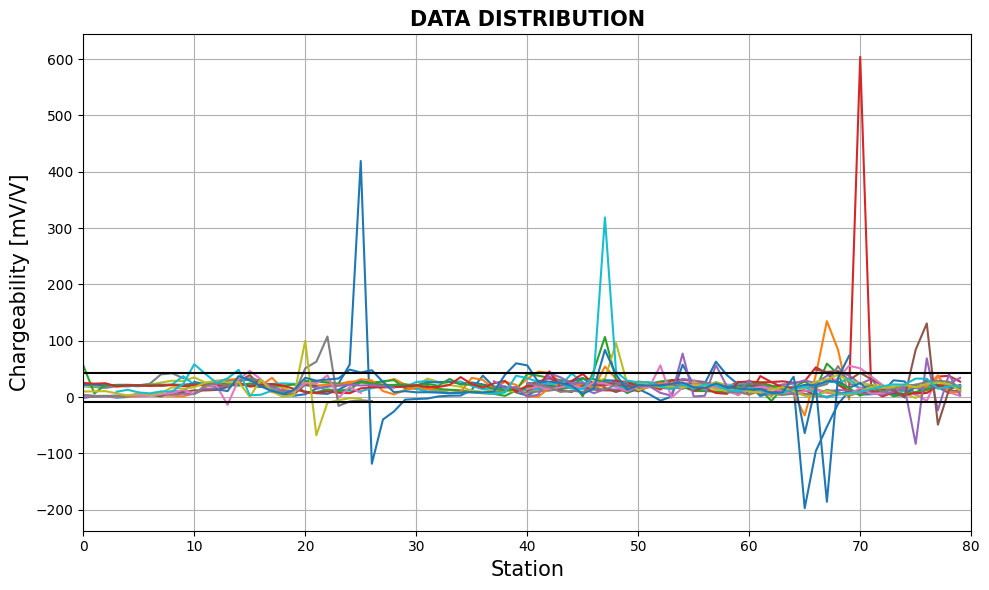

In [6]:
(IQR_Res, Max_Whisker_Res, Min_Whisker_Res) = quantiles(df_na,'Res')
(IQR_Char, Max_Whisker_Char, Min_Whisker_Char) = quantiles(df_na,'Char')
def Line_plot(df,lim_inf,lim_sup,Var1):

    xth = np.arange(0,80,1)
    fig,ax = plt.subplots(figsize=(10,6))
    grouped = df.groupby('Linea')
    for name, group in grouped:
        ax.plot(xth,group[Var1], label=name)
    ax.axhline(y = lim_sup, color= 'k', linestyle = '-')
    ax.axhline(y = lim_inf, color= 'k', linestyle = '-')
    ax.set_xlabel('Station',fontsize = 15)
    ax.set_ylabel(f"{variables[Var1][2]}",fontsize = 15)
    ax.set_title('DATA DISTRIBUTION',fontsize = 15,fontweight = "bold")
    plt.grid()
    plt.xlim(0,80)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

Line_plot(df,Min_Whisker_Char,Max_Whisker_Char,'Char')

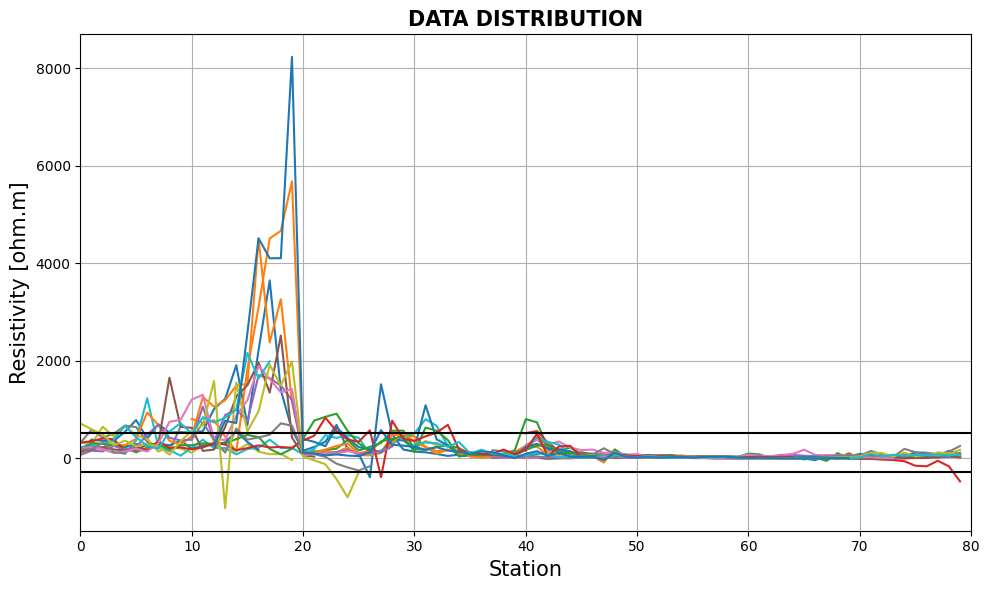

In [7]:
Line_plot(df,Min_Whisker_Res,Max_Whisker_Res,'Res')

Teniendo en cuenta que los outlayers de cargabilidad no se mantiene siguiendo una tendencia en una misma posición en ningun sentido, seran descartados. Sin embargo, este comportamiento no se mantiene para la resistividad ya que la mayoria de los outlayers estan ubicados siguiendo una tendencía hacia el norte la cual puede ser ocasionada por alguna forma geologica. Asi que para esta propiedad se van a eliminar algunos que sobresalen del bigote superior siguiendo un criterio empirico


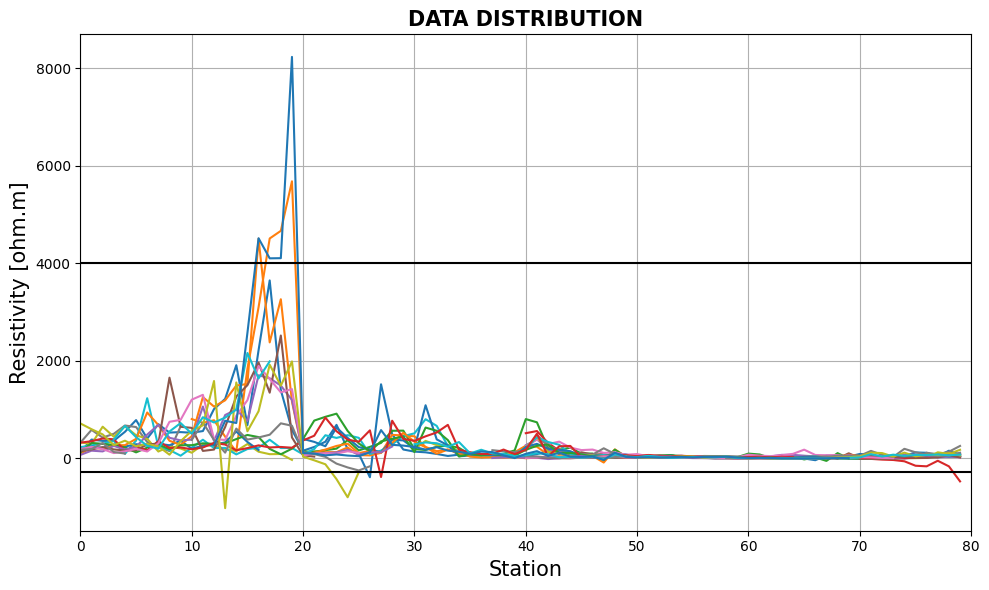

In [8]:
Line_plot(df,Min_Whisker_Res,4000,'Res')

In [9]:
def filt(df_emp, Var1, Limit_inf, Limit_sup):
    mask = (df_emp[Var1] < Limit_inf) | (df_emp[Var1] > Limit_sup)
    df_filtered = df_emp.copy()  # Create a copy of the DataFrame
    df_filtered.loc[mask, Var1] = None
    return df_filtered
    
df_emp_Res = filt(df_emp,'Res',Min_Whisker_Res,4000)
df_posit_Res = filt(df_emp,'Res',0,4000)
df_math_Char = filt(df_emp,'Char',Min_Whisker_Char,Max_Whisker_Char)
df_emp_Char = filt(df_emp,'Char',Min_Whisker_Char,150)
df_posit_Char = filt(df_emp,'Char',0,150)

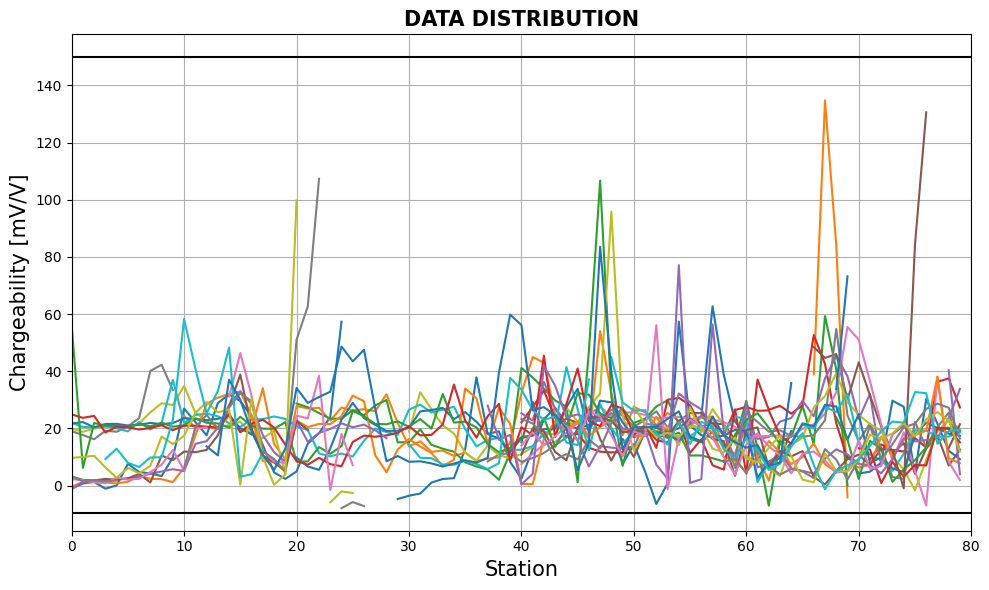

In [10]:
Line_plot(df_emp_Char,Min_Whisker_Char,150,'Char')

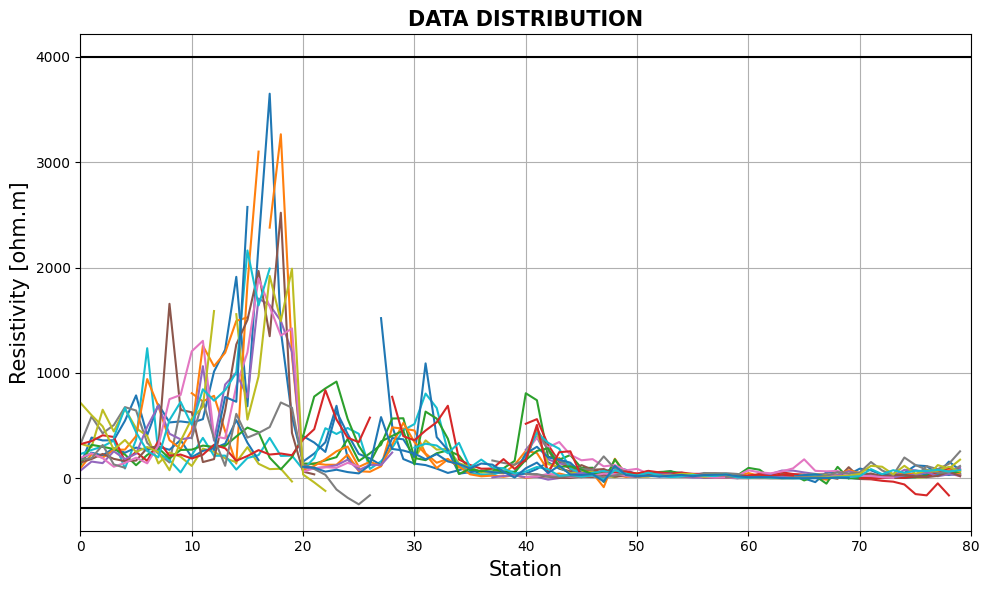

In [11]:
Line_plot(df_emp_Res,Min_Whisker_Res,4000,'Res')

We created a preliminary function to identify a trend with the variables that were acquired in the field depending on the line where the work team was located.


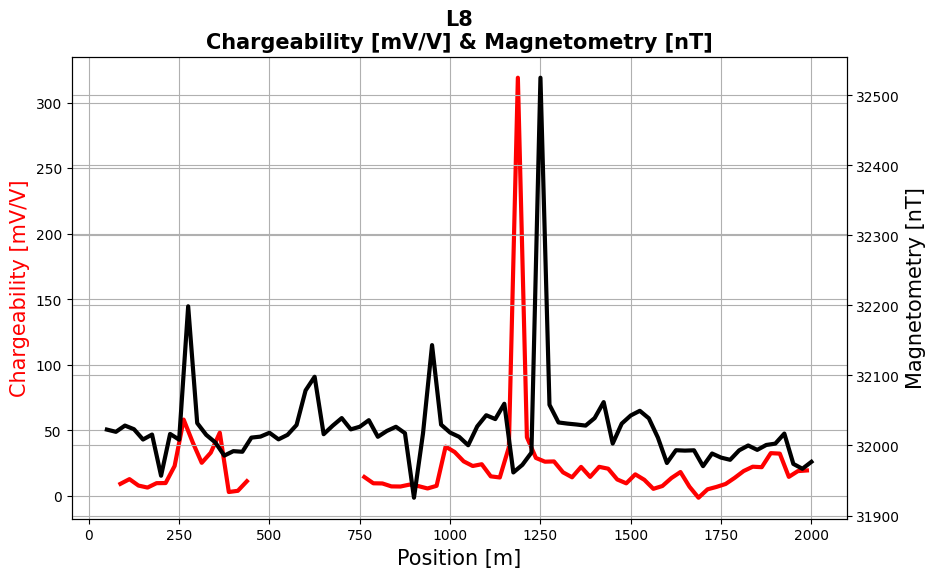

In [12]:
##### import matplotlib.pyplot as plt

def plot_line(df, df_mag, line, Variable_1, Variable_2):
    fig, ax = plt.subplots(figsize=(10,6))

    df_line = df.loc[lambda x: x['Linea'] == line]
    df_line_mag = df_mag.loc[lambda x: x['Linea'] == line]

    # Crear un diccionario para asignar colores y etiquetas a las variables
    variables = {'Char': ('r-', 'Chargeability [mV/V]'),
                  'Res': ('b-', 'Resistivity [ohm.m]'),
                  'Mag': ('k-', 'Magnetometry [nT]')}

    # Plotear la Variable_1
    if Variable_1 == 'Mag':
        ax.plot(df_line_mag['X'], df_line_mag[Variable_1], variables[Variable_1][0], linewidth=3, label=Variable_1)
        ax.set_xlabel('Position [m]', fontsize=15)
        ax.set_ylabel(variables[Variable_1][1], color=variables[Variable_1][0][0], fontsize=15)
        ax.grid()
    else :
        ax.plot(df_line['X'], df_line[Variable_1], variables[Variable_1][0], linewidth=3, label=Variable_1)
        ax.set_xlabel('Position [m]', fontsize=15)
        ax.set_ylabel(variables[Variable_1][1], color=variables[Variable_1][0][0], fontsize=15)
        ax.grid()

    # Plotear la Variable_2 si es diferente de Variable_1
    if Variable_2 != Variable_1:
        if Variable_2 == 'Mag':
            ax1 = ax.twinx()
            ax1.plot(df_line_mag['X'], df_line_mag[Variable_2], variables[Variable_2][0], linewidth=3, label=Variable_2)
            ax1.set_ylabel(variables[Variable_2][1], color=variables[Variable_2][0][0], fontsize=15)
            ax1.grid()
        else:
            ax1 = ax.twinx()
            ax1.plot(df_line['X'], df_line[Variable_2], variables[Variable_2][0], linewidth=3, label=Variable_2)
            ax1.set_ylabel(variables[Variable_2][1], color=variables[Variable_2][0][0], fontsize=15)
            ax1.grid()

    ax.set_title(f"{line}\n{variables[Variable_1][1]} & {variables[Variable_2][1]}", fontsize=15, fontweight='bold')

plot_line(df, df_mag, 'L8', 'Char', 'Mag')

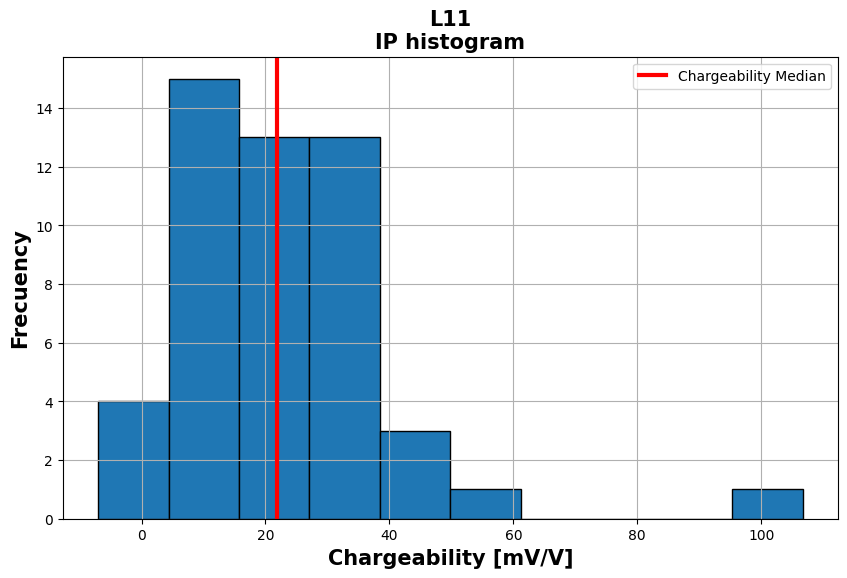

In [13]:
def hist(df, Var,line=None):

    if line is None:
        df_line = df
        line=""
    else:
        df_line = df.loc[lambda x: x['Linea'] == line]
    
    Median_label = {'Char': ('Chargeability Median'),
                'Res': ('Resistivity Median'),
                'Mag': ('Magnetometry Median')
                  }
    
    bins= np.linspace(-50,1100,num=20)
    median_value = np.percentile(df_line[Var], 50)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.hist(df_line[Var],edgecolor='black')
    plt.axvline(median_value,color='r', linewidth = 3,label=Median_label[Var])
    plt.xlabel(f"{variables[Var][2]}",fontsize=15,fontweight="bold")
    plt.ylabel('Frecuency',fontsize=15,fontweight="bold")
    plt.title(f"{line}\n""IP histogram",fontsize=15,fontweight="bold")
    plt.legend(fontsize=10)
hist(df_na,'Char','L11')

# <p style="background-color: rgb(73,68,33); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 3. Geological core data processing:</p>


At this point, a study of the drill cores which had already been logged was carried out for the identification and assignment of the rock lithology. For this study we worked with equipment that gave us information on chargeability and resistivity; in addition to working with the MPP and KT20 that gives us information on the magnetic susceptibility of the rocks.


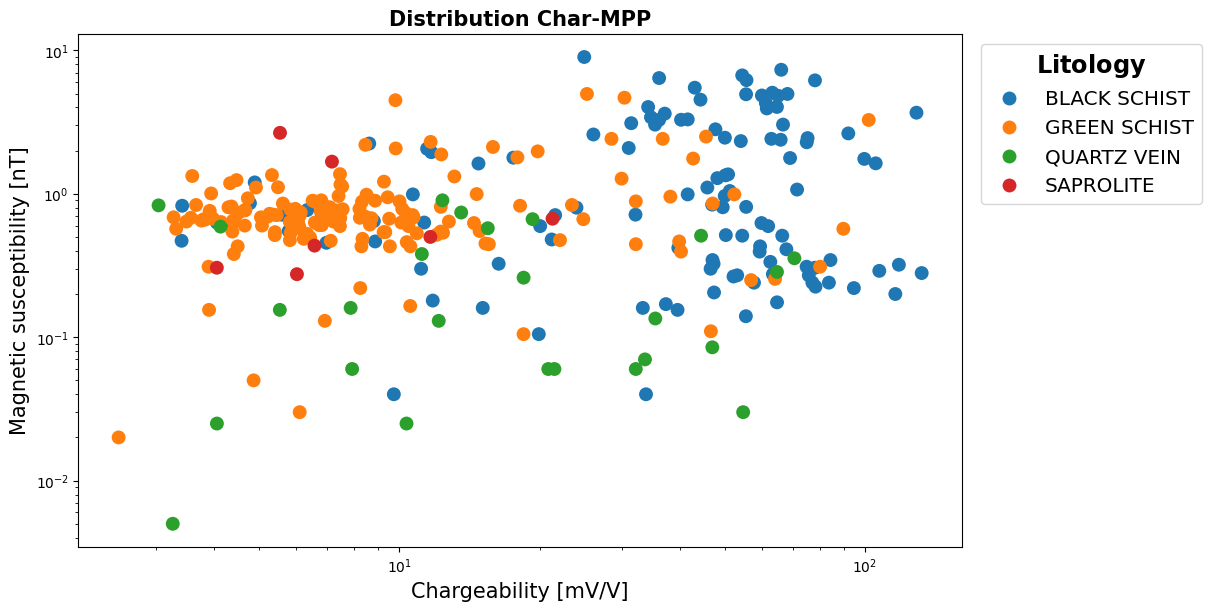

In [14]:
variables_drill = {'Char': ('r-','Chargeability Boxplot','Chargeability [mV/V]','Chargeability'),
                'Res': ('b-','Resistivity Boxplot', 'Resistivity [ohm.m]','Resistivity'),
                'KT20': ('k-','Magnetometry Boxplot', 'Magnetic susceptibility [nT]','Magnetic susceptibility'),
                'MPP': ('k-','Magnetometry Boxplot', 'Magnetic susceptibility [nT]','Magnetic susceptibility')
                  }

def scatter_drill(df,Var1,Var2):

    df = df.sort_values(by=['Lithology']).reset_index()
    fig, ax = plt.subplots(constrained_layout=True,figsize=(12,6))
    sns.scatterplot(x=df[Var1], y=df[Var2], data=df,s=100, hue=df['Lithology'], edgecolor="none")
    ax.set_xlabel(f"{variables_drill[Var1][2]}",fontsize=15)
    ax.set_ylabel(f"{variables_drill[Var2][2]}",fontsize=15)
    ax.set_title(f"Distribution {Var1}-{Var2}", fontsize=15, fontweight="bold")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(bbox_to_anchor=(1.01,1), loc="upper left",ncol=1,fontsize='x-large',title='$\\bf{Litology}$',
    title_fontsize='xx-large')
scatter_drill(df_drill,'Char','MPP')

Due to the amount of data available and the need for sufficient information to establish general patterns, we will focus only on the black shale and green shale lithologies for this analysis. These two lithologies have a higher representation in our database compared to the other lithologies, which allows us to perform a more robust and reliable analysis.


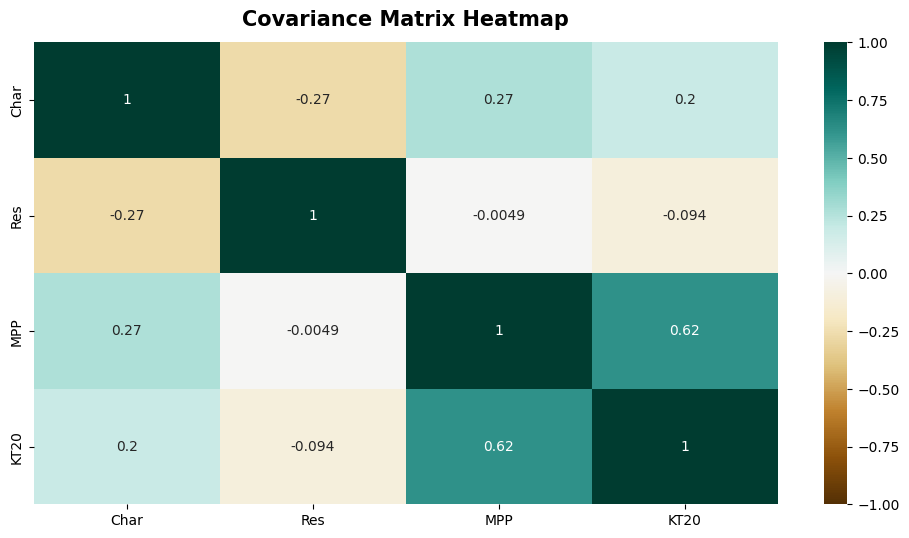

In [15]:
def heatmap(df):
    data_num = df.drop(df.select_dtypes(include=['object']).columns,axis=1)
    plt.figure(figsize=(12, 6))
    heatmap = sns.heatmap(data_num.corr(), vmin=-1, vmax=1, cmap='BrBG', annot=True)
    heatmap.set_title('Covariance Matrix Heatmap', fontdict={'fontsize':15}, pad=12, fontweight="bold");
heatmap(df_drill)

According to this result, there is a strong positive correlation as expected of the variable MPP and KT20 which are instruments that measure magnetic susceptibility. In addition, there is a slight correlation with the chargeability and magnetometry instruments.


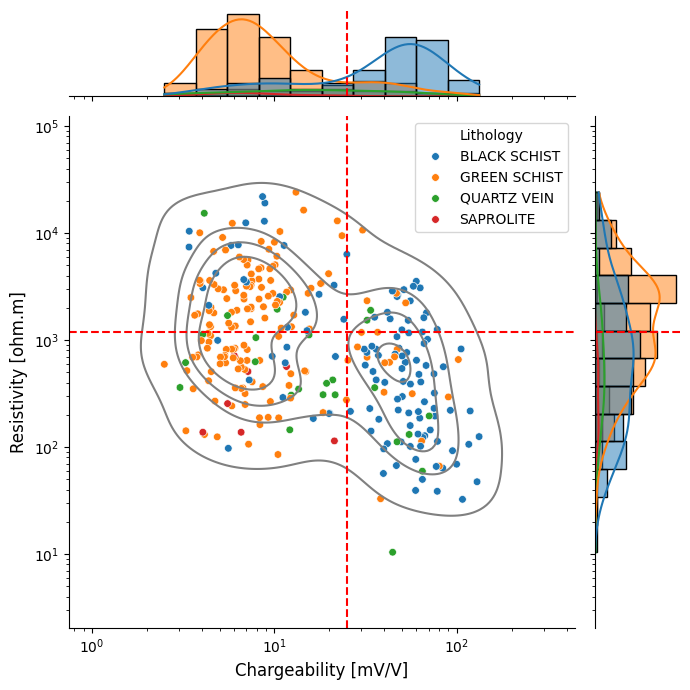

In [16]:
def jointgrid(df,Var1,Var2):
    g = sns.JointGrid(x=df[Var1], y=df[Var2], height=7)
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.plot_joint(sns.scatterplot, s=30, alpha=1,color='b', hue=df['Lithology'])
    g.plot_joint(sns.kdeplot,color='gray',levels=5)
    g.plot_marginals(sns.histplot, kde=True, hue=df['Lithology'])
    g.set_axis_labels(xlabel=f"{variables_drill[Var1][2]}",ylabel=f"{variables_drill[Var2][2]}", fontsize=12)
    g.refline(x=25, y=1200,color='r')
    plt.tight_layout()
jointgrid(df_drill,'Char','Res')

The scatter plot shows a normal behaviour in the resistivity variable of the lithologies identified with the highest concentration of data. In addition to a normal behaviour in the loadability with right and left skew taking into account the lithologies.


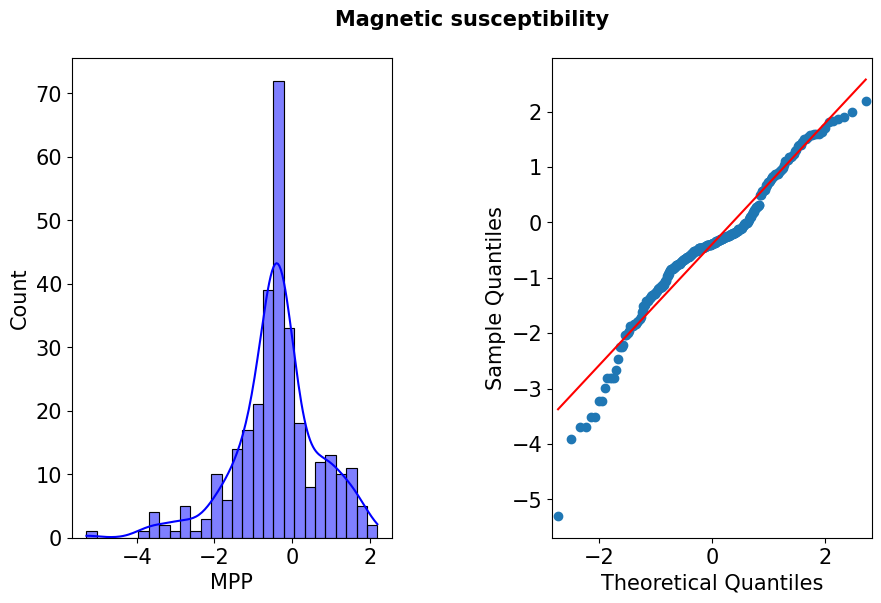

In [17]:
def Check_Normalized(df,Var1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle(variables_drill[Var1][3], fontsize=15, fontweight="bold")
    a=sns.histplot(np.log(df[Var1]),kde=True, color ='blue',ax=ax[0])
    b=sm.ProbPlot(np.log(df[Var1])).qqplot(line='s', ax=ax[1])
    plt.Axes.tick_params(a,axis='both',which='major',labelsize=15)
    ax[1].xaxis.set_tick_params(labelsize=15)
    ax[1].yaxis.set_tick_params(labelsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=15)
    ax[1].set_ylabel('Sample Quantiles', fontsize=15)
    ax[0].set_xlabel(Var1, fontsize=15)
    ax[0].set_ylabel('Count', fontsize=15)
    
    plt.subplots_adjust(wspace=0.5, hspace=0.3, left=0.1, right=0.9, bottom=0.1, top=0.9)

    
Check_Normalized(df_drill,'MPP')

# <p style="background-color: rgb(73,68,33); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 4. Contour plots and preliminary results:</p>


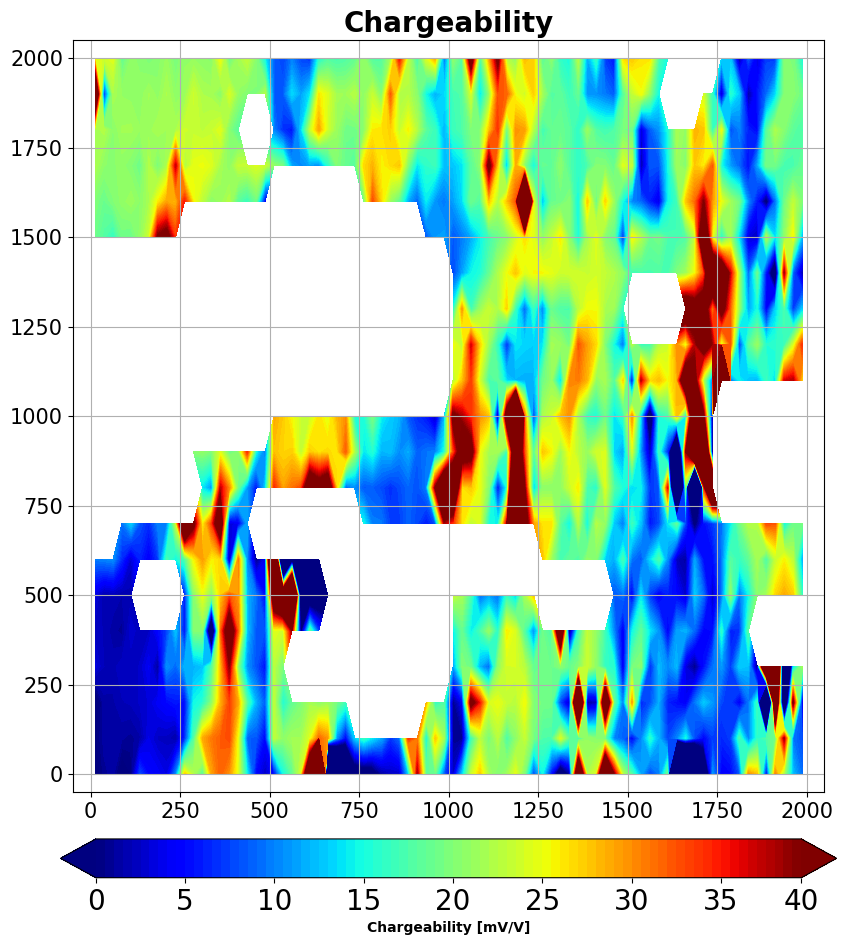

In [18]:
from matplotlib.ticker import FormatStrFormatter


cmap = {'Char': ('jet'),
                'Res': ('jet_r'),
                'Mag': ('jet'),
                'Lithology':('jet')
                  }


levels = np.arange(-50,500,.5)
bins = np.arange(-50,501,50)


level = np.arange(0,40,.5)
bin=[]
for i in range(0,43,5):
    bin.append(i)
    
    
levels_log = np.arange(0.1,1000,1)

def mapcontour(df,values,norm, bins, levels):
    
    Z = df.pivot_table(index='X', columns='Y', values=values).T.values
    X_unique = np.sort(df.X.unique())
    Y_unique = np.sort(df.Y.unique())
    X, Y = np.meshgrid(X_unique, Y_unique)
    X_unique,Y_unique
    pd.DataFrame(X).round(3)
    pd.DataFrame(Y).round(3)
    
    set_matplotlib_formats('png')

    rcParams['figure.figsize'] = 10, 10
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Generate a contour plot

    
    cp = ax.contourf(X, Y, Z, levels=levels, cmap=cmap[values], extend='both', norm=norm)
    cp = ax.contourf(X, Y, Z, levels=levels, cmap=cmap[values], extend='both', norm=norm)
        
    cb = fig.colorbar(cp, orientation="horizontal",ticks=bins,ax=ax,pad=0.05,shrink=0.8)
    cb.set_label(label=f"{variables[values][2]}", size=10, weight='bold')
    cb.ax.tick_params(labelsize=20)
    plt.title(variables[values][3],fontsize=20,fontweight="bold")
    plt.grid()
    plt.axis('square')
    plt.ylim(-50,2050)
    plt.xlim(-50,2050)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
mapcontour(df, 'Char' , None, bin, level)

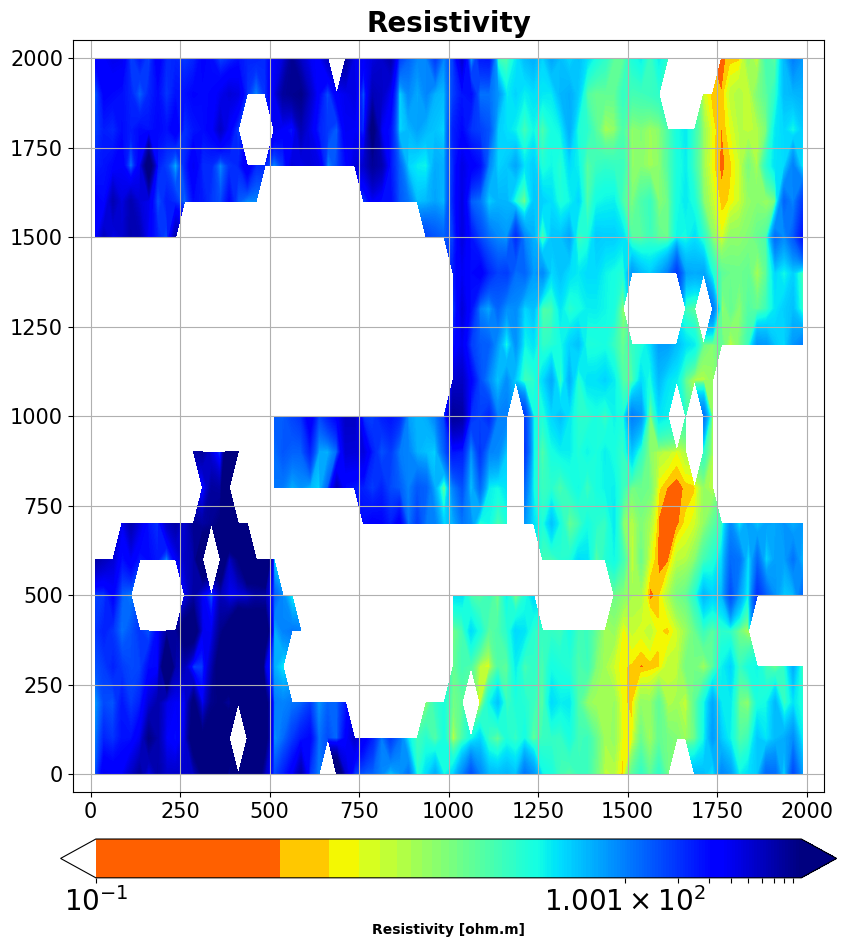

In [19]:
# linear, log, symlog, asinh, logit, function, functionlog
mapcontour(df_posit_Res,'Res','log', None , levels_log)

The results of the resistivity contour map show a very marked N-S trend in the eastern part of the map. This anomaly is associated with a regional fault that passes through the area.

On the other hand, to complete the data for each property, we use the method of least squares, which allows us to construct a mathematical function that has the best polynomial fit to the series of points in a given data set. Although the curves of a given fit are usually not unique, it is possible to find the curve with the minimum deviations at all points. That is, the minimum squared error of the data set assuming that the points are (𝑥1, 𝑦1), (𝑥2, 𝑦2),..., (𝑥𝑛, 𝑦𝑛) where ‘x’ is the independent variable and ‘y’ is the dependent variable. Moreover, for 𝑛 number of points, a polynomial of degree 𝑛 - 1 can be found.

On the other hand, as there are blanks in the data set, either due to omission of outliers or due to areas where it was not possible to enter measurements. The data are filled in linearly so that the method converges. Once the polynomial behaviour is obtained, the points are evaluated with the independent variable which, in this case, refers to the position of the measurement points


/var/folders/tm/ntqqt3b165j765q0kw8xndkh0000gn/T/ipykernel_12946/3963900867.py:15: RankWarning: Polyfit may be poorly conditioned
  p  = np.polyfit(df[stations][Resx],df[Var1][Resx],len(df[stations])-1)


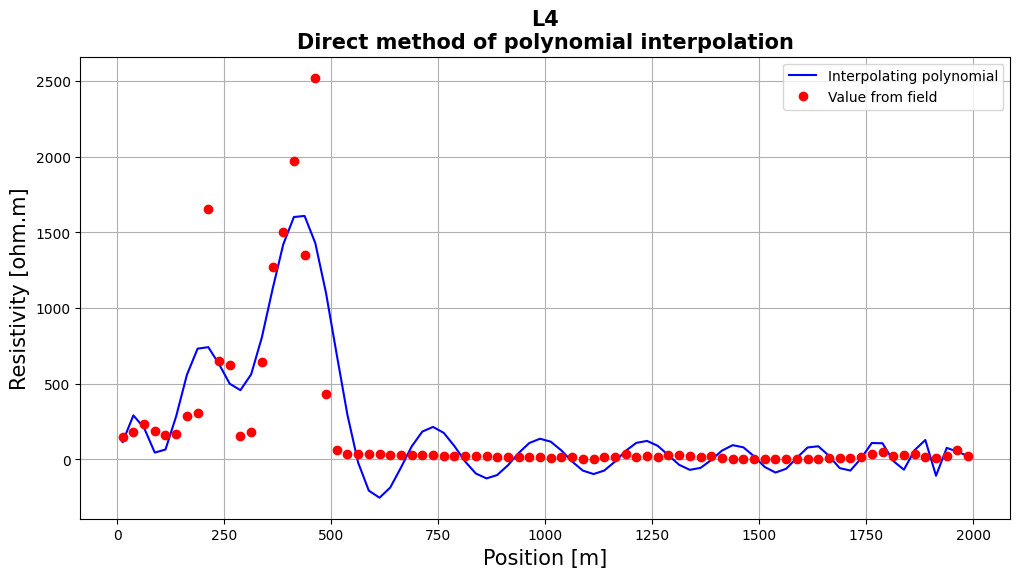

array([ 115.21960701,  291.14432555,  208.46484495,   45.27628309,
         65.46632295,  285.52527175,  558.53358133,  731.4371419 ,
        741.49175251,  629.98960984,  500.16847261,  457.31044508,
        560.97166796,  804.45924557, 1122.58200818, 1419.07551185,
       1600.9789788 , 1607.93705819, 1428.31601972, 1099.29992376,
        693.10312371,  294.92052377,  -20.33887734, -206.11281644,
       -252.80730348, -185.73428959,  -54.06998706,   85.27609411,
        184.03130921,  214.70905024,  175.60481569,   87.89835449,
        -13.63582456,  -93.10702736, -125.25044355, -102.92615237,
        -38.28919455,   42.45123973,  108.76285701,  136.68470184,
        117.19345011,   59.17036129,  -14.10579309,  -73.78201775,
        -96.46544209,  -73.40346057,  -14.2036834 ,   56.6617636 ,
        109.60375177,  122.32416302,   89.81441447,   27.34317482,
        -35.61956175,  -68.70900542,  -55.65378497,   -3.66841915,
         58.44372215,   94.2608072 ,   80.02269988,   20.51716

In [20]:
def Data_complete(df,stations,Var1,line):

    df = df.loc[lambda x: x['Linea'] == line]

    nan = np.nan
    ok = ~np.isnan(df[Var1])
    xp = ok.ravel().nonzero()[0]
    fp = df[Var1][~np.isnan(df[Var1])]
    x  = np.isnan(df[Var1]).ravel().nonzero()[0]
    df[Var1][np.isnan(df[Var1])] = np.interp(x, xp, fp)
    
    Resx = np.isfinite(df[Var1]) & np.isfinite(df[stations])
    
    xp = np.linspace(min(df[stations]),max(df[stations]))
    p  = np.polyfit(df[stations][Resx],df[Var1][Resx],len(df[stations])-1)
    yp = np.polyval(p,df[stations])
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(df[stations],yp,'b-', label = 'Interpolating polynomial')
    plt.plot( df[stations], df[Var1],'ro', label = 'Value from field')
    plt.xlabel('Position [m]', fontsize=15)
    plt.ylabel(f"{variables[Var1][2]}", color='k', fontsize=15)
    plt.title(f"{line}\n""Direct method of polynomial interpolation", fontsize=15,fontweight="bold")
    plt.legend(fontsize=10)
    plt.show()

    return yp

Data_complete(df_emp_Res,'X','Res','L4')

In [21]:
%%capture output
data = {'linea': [],
        'X': [],
        'Y': [],
        'Char': [],
        'Res': []}
new_df = pd.DataFrame(data)
appended_rows = []
for l in df['Linea'].unique():
    df_new = df[df['Linea'] == l]
    
    res = Data_complete(df_emp_Res, 'X', 'Res', l)
    car = Data_complete(df_math_Char, 'X', 'Char', l)
    l = np.full(df_new['X'].shape[0], l)
    print(l.shape)
    print(df_new['X'].shape)
    print(df_new['Y'].shape)
    print(car.shape)
    print(res.shape)
    rows = pd.DataFrame({'linea': [l],  'X': [df_new['X']], 'Y': [df_new['Y']], 'Char': [car], 'Res': [res]})
    appended_rows.append(rows)

my_array = np.array(appended_rows)
my_array.shape
#my_df = pd.DataFrame(ar)
df_DATA = pd.DataFrame(my_array.reshape(-1, 5), columns=['Linea', 'X', 'Y', 'Char', 'Res'])

In [22]:
df_new = df_DATA.explode(['Linea','X','Y','Char','Res'])
df_new['Res'] = df_new['Res'].astype(float)
df_new['Char'] = df_new['Char'].astype(float)

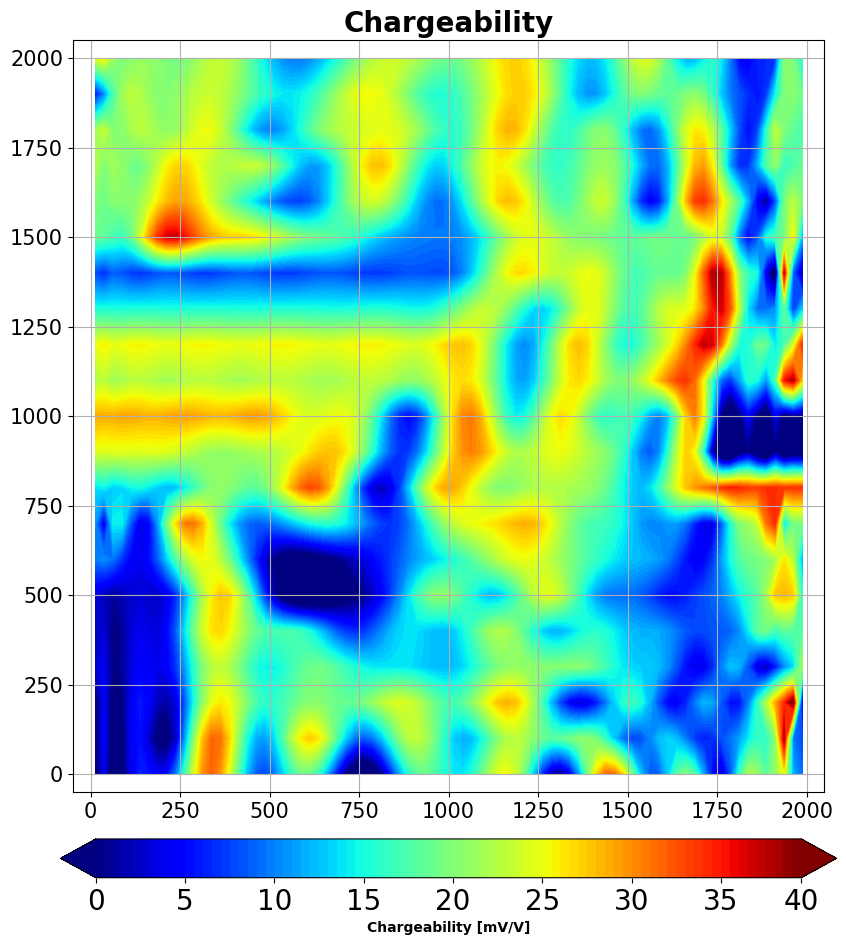

In [23]:
mapcontour(df_new, 'Char' , None, bin, level)

Taking into account that some large areas were filled by the least squares method, it was decided to eliminate the noisy areas that can be identified in the contour plot because initially there were no data and they start to show geological trends that are not true.


In [24]:
df_neww=df_new
df_neww = df_neww[~((df_neww['X'] > 0) & (df_neww['X'] < 1000) & (df_neww['Y'] > 1000) & (df_neww['Y'] < 1500))]
df_neww = df_neww[~((df_neww['X'] > 1750) & (df_neww['X'] < 2000) & (df_neww['Y'] > 750) & (df_neww['Y'] < 1100))]
df_neww = df_neww[~((df_neww['X'] > 500) & (df_neww['X'] < 1000) & (df_neww['Y'] > 250) & (df_neww['Y'] < 750))]
df_neww = df_neww .reset_index(drop=True)
df_neww 

,Linea,X,Y,Char,Res
0,L1,12.5,0,-1.695930,117.102235
1,L1,37.5,0,3.929985,431.997975
2,L1,62.5,0,-2.863811,339.156042
3,L1,87.5,0,-1.363444,347.621619
4,L1,112.5,0,3.542005,504.184025
...,...,...,...,...,...
1385,L21,1887.5,2000,6.421526,-14.460544
1386,L21,1912.5,2000,6.697388,45.016050
1387,L21,1937.5,2000,20.534354,44.214885
1388,L21,1962.5,2000,19.745884,102.445254


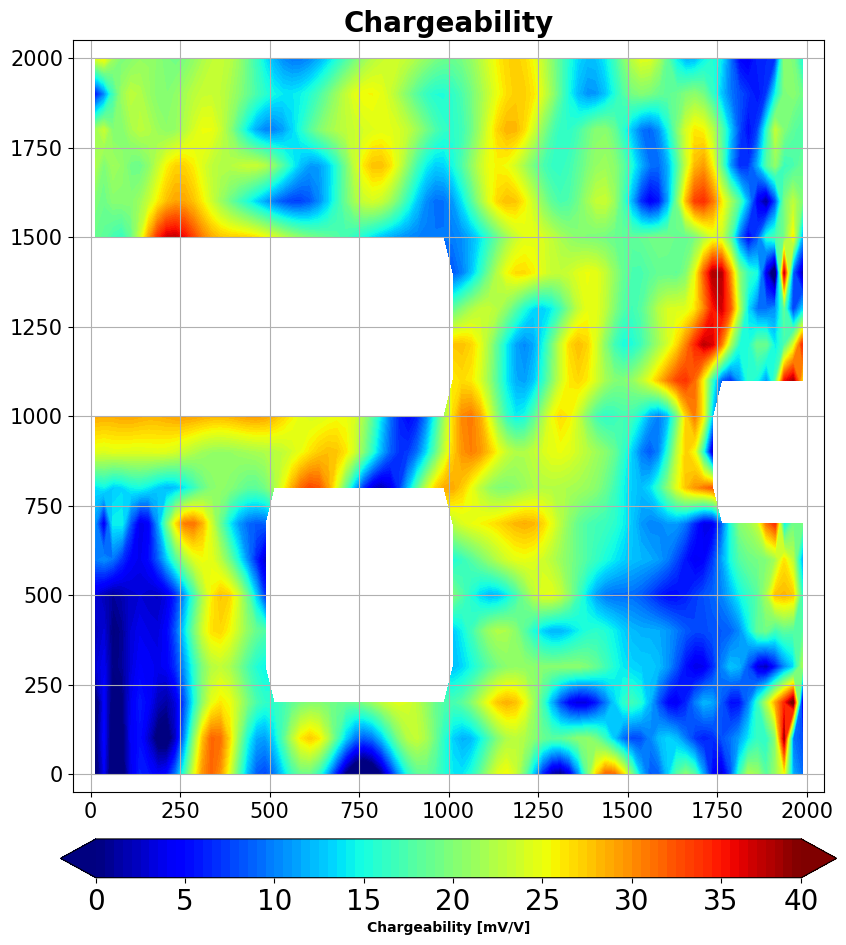

In [25]:
mapcontour(df_neww, 'Char' , None, bin, level)

This process only works with the Chargeability data as they have variable behaviours with a very small deviation unlike the resistivity data.
Given this conclusion, we will continue to work with the data that had not been altered with the least squares regression.


# <p style="background-color: rgb(73,68,33); font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:50px 50px;"> 5. Machine Learning:</p>


In [26]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
encoder = OrdinalEncoder()

In [27]:
df_fil = df_drill[df_drill['Lithology'].isin(['BLACK SCHIST', 'GREEN SCHIST'])]
df_fil

,Char,Res,MPP,KT20,Lithology
0,132.4975,125.340,0.280,3.935,BLACK SCHIST
1,129.1250,47.460,3.675,4.885,BLACK SCHIST
2,118.3725,217.615,0.320,2.315,BLACK SCHIST
3,116.2990,106.150,0.200,3.480,BLACK SCHIST
4,107.4295,32.490,0.290,1.850,BLACK SCHIST
...,...,...,...,...,...
302,3.4120,10415.000,0.825,3.605,BLACK SCHIST
303,3.4020,7406.065,0.470,2.940,BLACK SCHIST
304,3.3120,518.050,0.570,3.490,GREEN SCHIST
305,3.2700,142.100,0.685,4.495,GREEN SCHIST


In [28]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

encoder = OrdinalEncoder()
y = encoder.fit_transform(df_fil[['Lithology']])
y = y.ravel()
X = df_fil.drop (['Lithology','MPP','KT20'], axis = 1)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(277, 2)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

RandomForestRegressor : 0.347
GradientBoostingRegressor : 0.325
KNeighborsClassifier : 0.792
MLPClassifier : 0.819


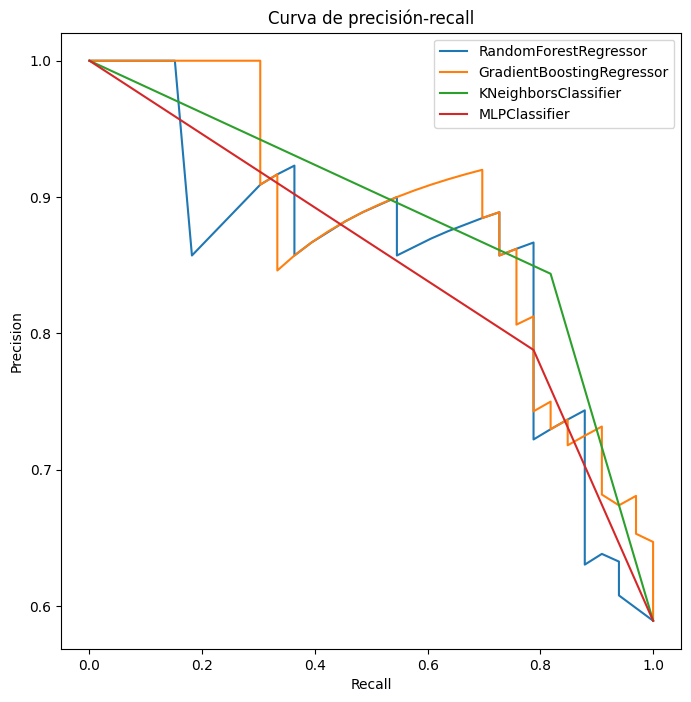

In [30]:
Models = (
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    KNeighborsClassifier(n_neighbors=3),
    MLPClassifier(hidden_layer_sizes=(10 ,10), max_iter=1000, random_state=42)  
)

for model in Models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = scores.mean()
    formatted_score = "{:.3f}".format(mean_score)
    print(model.__class__.__name__, ":", formatted_score)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    y_true = y_test
    
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    rcParams['figure.figsize'] = 8, 8
    # Grafica la precisión y el recall
    plt.plot(recall, precision, label=model.__class__.__name__)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de precisión-recall')
    plt.legend()


In [31]:
%%capture output

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['identity', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant','adaptive']
}

model = MLPClassifier()
model_f = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=2)
model_f.fit(X_train, y_train)

In [32]:
print("Mejores hiperparámetros:", model_f.best_params_)
print("Rendimiento del modelo:", "{:.2f}".format(model_f.best_score_))

Mejores hiperparámetros: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Rendimiento del modelo: 0.84


In conclusion, the Chargeability and Resistivity contour plots prove to be effective in the interpretation of the results obtained by the IP method for the exploration of vetiform deposits, as they highlight in a suitable way the main directions of the veins with N-S direction.
Moreover, there is a correlation between the magnetic properties and the response to chargeability, suggesting a relationship between deposits containing magnetic minerals such as magnetite and haematite, and the magnetic response to chargeability.
such as magnetite and haematite, with conductive minerals such as graphite, chalcopyrite and other sulphides depending on the geology of the area.

From the machine learning model, knowing the geophysical properties of the rocks we could have an idea of the type of schist in the area, however the model is very limited as there were other rocks in the project but we did not have clear information or enough to train our model. On the other hand, to finalise the whole process, it was decided to scale the geophysical field data and evaluate the model on surface to estimate how close it is to the reality of the geology in the project.


In [33]:
scaler.fit(df[['Res', 'Char']])
df_scaled = scaler.transform(df[['Res', 'Char']])
df_scaled
print(df.isnull().any())

df['Res'].fillna(df['Res'].mean(), inplace=True)
df['Char'].fillna(df['Char'].mode()[0], inplace=True)
scaler.fit(df[['Res', 'Char']])
df_scaled = scaler.transform(df[['Res', 'Char']])
df_scaled
print(df.isnull().any())

Linea    False
X        False
Y        False
Res       True
Char      True
dtype: bool
Linea    False
X        False
Y        False
Res      False
Char     False
dtype: bool


In [34]:
new_predictions = model_f.predict(df_scaled)
New_predic = pd.DataFrame(new_predictions,columns=['Lithology'])
New_predic[New_predic['Lithology'] == 0]

,Lithology
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
...,...
1630,0.0
1631,0.0
1632,0.0
1633,0.0


In [35]:
df_predi = pd.concat([df,  New_predic], axis=1)

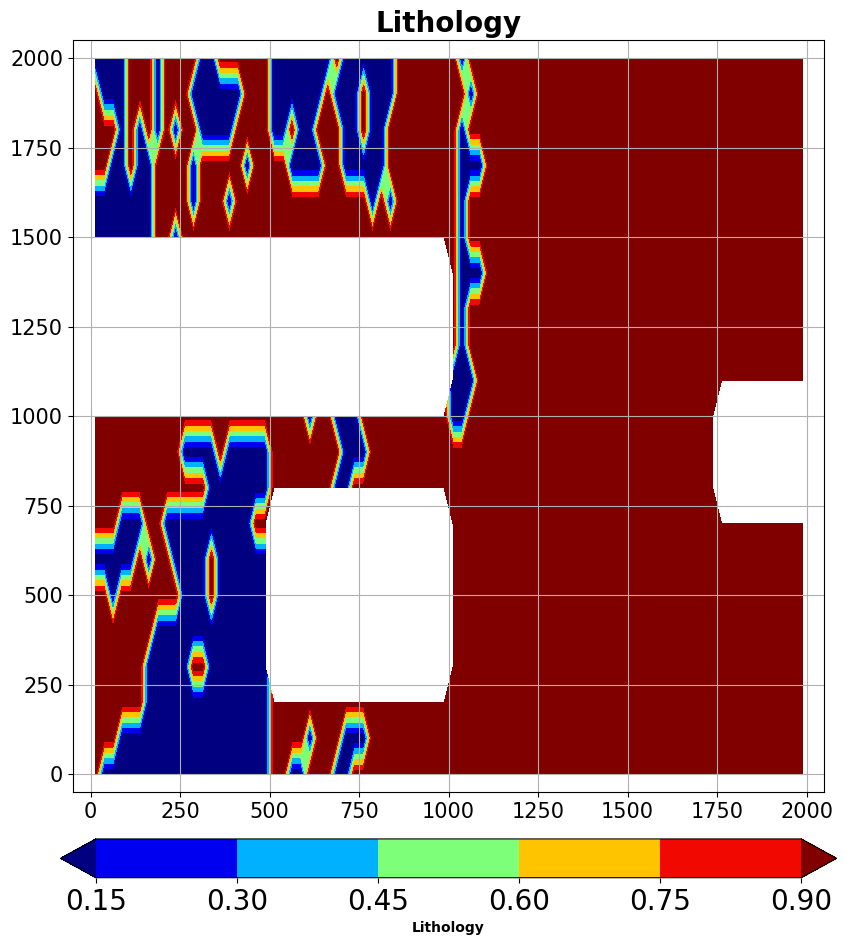

In [36]:
df_predi = df_predi[~((df_predi['X'] > 0) & (df_predi['X'] < 1000) & (df_predi['Y'] > 1000) & (df_predi['Y'] < 1500))]
df_predi = df_predi[~((df_predi['X'] > 1750) & (df_predi['X'] < 2000) & (df_predi['Y'] > 750) & (df_predi['Y'] < 1100))]
df_predi = df_predi[~((df_predi['X'] > 500) & (df_predi['X'] < 1000) & (df_predi['Y'] > 250) & (df_predi['Y'] < 750))]
df_predi = df_predi .reset_index(drop=True)
mapcontour(df_predi, 'Lithology' , None, None, None)